# Points tracking - **`OpticalFlowPyrLK`**

Here we want to develop a code that given the coordinates of an important point on the image it mantains its location during the video.

In [1]:
# Import required libraries
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the video
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / "recording_2" / "Recording_2.mp4")
OUTPUT_VIDEO_PATH = str(
    PROJECT_ROOT / "data" / "recording_2" / "Recording_2_points_tracked.mp4"
)
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (frame_width, frame_height))

# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, 1)
ret, frame = cap.read()
if not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

In [3]:
%run -i ~/projects/IACV_project/bowling-analysis/notebook/various_tests/Manual_point_acquisition.py

Selected Points: [(1333, 460), (962, 450)]


- Selected Points for Recording_2: [(1337, 454), (958, 451)]

- Selected Points for Recording_3: [(1544, 445), (1256, 440)]

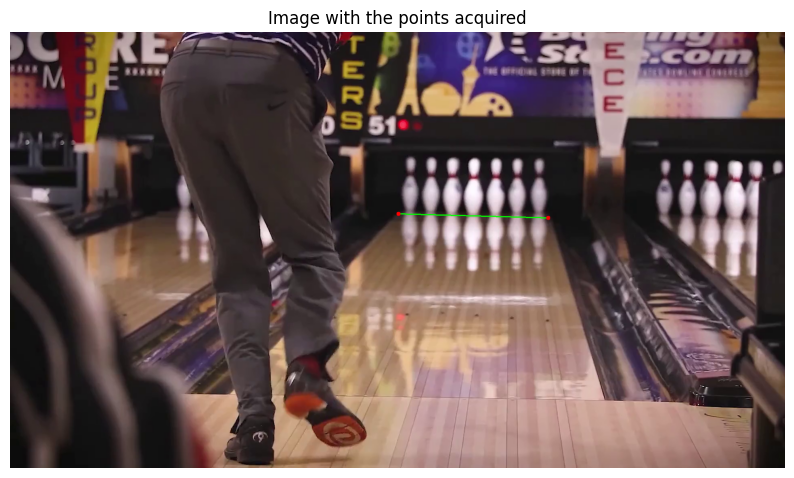

In [4]:
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


showImage(frame, "Image with the points acquired")

Now that I have the coordinates of the points I want to track, for all frames I want to mantain these points during the video

In [13]:
# Define points to track
points = np.array([[1338, 453], [956, 452]], dtype=np.float32)

# Define parameters for Lucas-Kanade Optical Flow
lk_params = dict(
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
)

# Convert the first frame to grayscale
prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [14]:
# Track the points across frames
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow for the points from previous frame to current frame
    new_points, status, _ = cv2.calcOpticalFlowPyrLK(
        prev_gray, gray, points, None, **lk_params
    )

    # Ensure that status array has the same number of points
    if new_points is not None and status is not None:
        # Select good points
        good_new = new_points[
            status.flatten() == 1
        ]  # Flatten status to handle as 1D array
        good_old = points[status.flatten() == 1]

        # Draw the points
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            frame = cv2.line(frame, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    # Write the frame with tracked points to the output video
    out.write(frame)

    # Display result
    cv2.imshow("Tracking", frame)

    # Exit if ESC pressed
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

    # Update previous frame and points
    prev_gray = gray.copy()
    points = good_new.reshape(-1, 1, 2)

cap.release()
out.release()

cv2.destroyAllWindows()

print("Tracking video saved successfully to:", OUTPUT_VIDEO_PATH)

Tracking video saved successfully to: /home/davic/projects/IACV_project/bowling-analysis/data/recording_3/Recording_3_points_tracked.mp4
